In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import larch
from larch.data_warehouse import example_file
from larch import P,X

# Nested Logit

## Theory Review

- The Independence of Irrelevant Alternatives Property (IIA) property of the Multinomial Logit (MNL) model makes that model unsuitable for application in situations in which some choices share both observed and unobserved attributes.

- The sharing of unobserved attributes among alternatives violates the IID assumption used in the development of the MNL model and leads to increased competitiveness between those alternatives. 

- Consider urban mode choice with four alternatives of which two, Bus and Light Rail, are public transit alternatives (similar with respect to a variety of variables including common fare structure, same management and staff, same operating policies, lack of privacy, etc.). 

- Some of these attributes, such as fares and operating hours, may be observed while others may not be observed. These relationships can be depicted by the following “tree” structure:

In [68]:
from larch.model.tree import NestingTree
t = NestingTree()
# t.add_node(0, name='mode', root=True)
da = t.new_node(name='Drive Alone')
sr = t.new_node(name='Shared Ride')
bus = t.new_node(name='Bus')
ltr = t.new_node(name='Light Rail')
tr = t.new_node(name='Transit', children=[3,4])
# t._root_id = "modes"
t

In [60]:
t._root_id

0

The utility equations for the public transit alternatives include a shared unobserved portion, denoted $\varepsilon_{PT}$.

$$
{U_{DA}}={V_{DA}}+{\varepsilon_{DA}}\\{U_{SR}}={V_{SR}}+{\varepsilon_{SR}}\\{U_{Bus}}={V_{Bus}}+{\varepsilon_{PT}}+{\varepsilon_{Bus}}\\{U_{LTR}}={V_{LTR}}+{\varepsilon_{PT}}+{\varepsilon_{LTR}}
$$

The unobserved components for drive alone and shared ride are distributed

$$
{\varepsilon_{DA}},{\varepsilon_{SR}}\sim G(0,1)
$$

The unobserved components of bus and light rail are divided into two components. The distinct components for bus and light rail are represented by independent and identically distributed Gumbel random variables with variance parameter, $\mu_{PT}$ 

$$
{\varepsilon_{Bus}},{\varepsilon_{LTR}}\sim G(0,{\mu_{PT}})
$$

The common or shared component, $\varepsilon_{PT}$, is distributed such that the sum of both distributions is Gumbel(0, 1); that is,

$$
\begin{array}{l}
\varepsilon_{PT}+{\varepsilon_{Bus}}\sim G(0,1)\\
{\varepsilon_{PT}}+{\varepsilon_{LTR}}\sim G(0,1)
\end{array}
$$

$\mu_{PT}$ must be between zero and one to ensure that the variance of the distinct components is less than or equal to the total error variance. 

These assumptions are used to derive a nested logit model for the choice among these four alternatives based on utility maximization. 

We can describe this problem as if there are two levels of choice: a marginal choice among drive alone, shared ride and public transit and a conditional choice between bus and light rail if public transit is chosen. However, no behavioral choice sequence can be inferred from the NL structure. 

First, consider the conditional choice between bus and light rail:

$$
\begin{align}
P_{Bus|PT}	&=\Pr\left[{{U_{BUS}}\ge{U_{LTR}}}\right]\\
	&=\Pr\left[{{V_{BUS}}+{\varepsilon_{PT}}+{\varepsilon_{BUS}}\le{V_{LTR}}+{\varepsilon_{PT}}+{\varepsilon_{LTR}}}\right]\\
	&=\Pr\left[{{V_{BUS}}+{\varepsilon_{BUS}}\ge{V_{LTR}}+{\varepsilon_{LTR}}}\right]\\
	&=\Pr\left[{{\varepsilon_{LTR}}\le{V_{BUS}}-{V_{LTR}}+{\varepsilon_{BUS}}}\right]
\end{align}
$$

Since ${\varepsilon_{bus}}$ and $\varepsilon_{LTR}$ are IID Gumbel(0,$\mu_{PT}$),

$$
{P_{Bus|PT}}=\frac{{\exp\left({{V_{Bus}}/{\mu_{PT}}}\right)}}{{\sum\limits _{PTM=Bus,LTR}{\exp\left({{V_{PTM}}/{\mu_{PT}}}\right)}}}
$$

and similarly for the probability of LTR conditional on PT.

The utility parameters in this expression are estimable only up to the scale of $\beta_{k}/\mu_{PT}$.

Next, consider the marginal choice between drive alone, shared ride and public transit:

$$
\begin{align}
P_{DA}	&=	\Pr\left[{{U_{DA}}\ge{U_{SR}},{U_{Bus}},{U_{LTR}}}\right]\\
	&=	\Pr\left[{{U_{DA}}\ge{U_{SR}},\max\left\{ {{U_{Bus}},{U_{LTR}}}\right\} }\right]
\end{align}
$$

Recall, the maximum of two IID Gumbel variates is a Gumbel variate with location parameter equal to the log sum of the exponents of the original location parameters, we can replace the maximization expression in the utility of public transportation by $U_{PT}$, the utility of the set of public transit modes, which is distributed 

$$
G(0,{\mu^{PTM}})
$$

That is,

$$
\begin{array}{l}
{U_{PT}}=\max\left\{ {{U_{Bus}},{U_{LTR}}}\right\} =\mu_{PT}\log\left({\exp\left({{V_{Bus}}/\mu_{PT}}\right)+\exp\left(V_{LTR}/\mu_{PT}\right)}\right)+{\varepsilon_{PT}}+{\varepsilon_{PTM}}\\
{U_{PT}}=\max\left\{ {{U_{Bus}},{U_{LTR}}}\right\} =\mu_{PT}{\Gamma_{PT}}+\varepsilon_{PT}^{*}
\end{array}
$$

where $\Gamma_{PT}=\log\left({\exp\left({{V_{Bus}}/\mu_{PT}}\right)+\exp\left(V_{LTR}/\mu_{PT}\right)}\right)$.

- Thus, 

$$
\begin{array}{l}
P(DA)=\frac{{\exp({V_{DA}})}}{{\exp({V_{DA}})+\exp({V_{SR}})+\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}}\\
P(SR)=\frac{{\exp({V_{SR}})}}{{\exp({V_{DA}})+\exp({V_{SR}})+\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}}\\
P(PT)=\frac{{\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}}{\begin{array}{l}
\exp({V_{DA}})+\exp({V_{SR}})+\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)\end{array}}
\end{array}
$$

Estimation of the conditional choice model includes estimation of ${\mu_{PT}}$. Consistent estimates for the parameters in the conditional, Bus vs LTR, model can be obtained by multiplying the conditional estimates by the scale parameter, ${\mu_{PT}}$, estimated in the marginal model. 

### Statistical Testing of Nested Logit Structures

Adopting a nested logit model implies rejection of the MNL. Tests can also be made between any NL and a simpler NL that is a reduced form of the initial model. 

#### Full Nesting Structure Test

We can use standard statistical tests of the hypothesis that the MNL model is the true model since the nested logit model is a generalization of the MNL model. In the case of multiple nests, the hypothesis that the MNL is the true model is equivalent to the hypothesis that all the logsum parameters are equal to one. 

Use the **likelihood ratio test** (Chi Squared or $\chi^2$) to compare a nested logit model against the equivalent MNL model, with degrees of freedom equal to the number of logsum parameters.

#### Single Nest Test

To test whether a single logsum parameter is significant, use the $t$ statistic.  

Unlike for $\beta$ parameters in the utility function, the default "null" value for logsum parameters
is 1.0.  For nests just under the root node, we can compare directly against 1.

$$
\mathrm{t-statistic}=\frac{\hat{\mu}_{k}-1}{s_{k}}
$$

where $\hat{\mu}_{k}$ is the estimate of the logsum parameter for nest $k$, 1 is the hypothesized value against which the logsum parameter is being tested, and $s_{k}$ is the standard error of the parameter estimate.

For other nests, we need to compare not against 1 but against the value of the logsum parameter of the nest above.

$$
\mathrm{t-statistic}=\frac{\hat{\mu}_{k}-\hat{\mu}_{j}}{\sqrt{s_{k}^{2}+s_{j}^{2}-2s_{k,j}}}
$$

where 

- $\hat{\theta}_{k}$ is the estimate of the logsum parameter 
  for nest $k$ that is included under nest $j$, 
- $\hat{\theta}_{j}$ is the estimate of the logsum parameter for 
  nest $j$, 
- $s_{k}^{2}$ is the error variance of the logsum parameter 
  for nest $k$ that is included under nest j, 
- $s_{j}^{2}$ is the error 
  variance of the logsum parameter for nest $j$, and 
- $s_{k,j}$ is the error covariance of the two logsum parameters.

It is important to note that these are not necessarily the test values that will be reported by all computer programs, many of which apply the test for the null hypothesis that the logsum is equal to zero or one only. 

### Multiple Nests

Extension of above results is that the structural effect for alternatives 
which are not in any common nest is the same as for the MNL. 
Note: it is not necessary for the logsum parameters to be equal for different nests. 

In [3]:
t = NestingTree()
da = t.new_node(name='Drive Alone')
sr = t.new_node(name='Shared Ride')
bus = t.new_node(name='Bus')
ltr = t.new_node(name='Light Rail')
tr = t.new_node(name='Transit', children=[bus,ltr])
ca = t.new_node(name='Car', children=[da,sr])
t

Note that it is not necessary for the logsum parameters $\mu_{Transit}$ and $\mu_{Car}$ to be the same for the
Transit and Car nests. However, both must meet the same original requirements: values greater than 0 and less than or equal to 1.

#### Hierarchical Nests

We can also write the NL model with one nest inside another nest.

In [4]:
t = NestingTree()
da = t.new_node(name='Drive Alone')
sr = t.new_node(name='Shared Ride')
bus = t.new_node(name='Bus')
ltr = t.new_node(name='Light Rail')
tr = t.new_node(name='Transit', children=[bus,ltr])
sh = t.new_node(name='Shared', children=[tr,sr])
t

When a nest is inside another nest, the entire structure repeats itself inside the utility of the middle nest.

So, the variance restrictions will still apply: variance inside the lower nest must not exceed variance at the higher levels.  We can conceptualize this by writing out utility functions:

$$
{U_{DA}}={V_{DA}}+{\varepsilon_{DA}}\\
{U_{SR}}={V_{SR}}+{\varepsilon_{Share}}+{\varepsilon_{SR}}\\
{U_{Bus}}={V_{Bus}}+{\varepsilon_{Share}}+{\varepsilon_{PT}}+{\varepsilon_{Bus}}\\
{U_{LTR}}={V_{LTR}}+{\varepsilon_{Share}}+{\varepsilon_{PT}}+{\varepsilon_{LTR}}
$$

The unobserved components of bus and light rail are divided into *three* components. The distinct components for bus and light rail are represented by independent and identically distributed Gumbel random variables with variance parameter, $\mu_{PT}$ 

$$
{\varepsilon_{Bus}},{\varepsilon_{LTR}}\sim G(0,{\mu_{PT}})
$$

The Transit common component, $\varepsilon_{PT}$, is distributed such that the sum of it and the lower level distributions is Gumbel(0, $\mu_{Share}$); that is,

$$
\begin{array}{l}
\varepsilon_{PT}+{\varepsilon_{Bus}}\sim G(0,\mu_{Share})\\
{\varepsilon_{PT}}+{\varepsilon_{LTR}}\sim G(0,\mu_{Share})
\end{array}
$$

The $\varepsilon_{SR}$ term has the same distribution, but just by itself.

$$
\varepsilon_{SR}\sim G(0,{\mu_{Share}})
$$

The higher level common component, $\varepsilon_{Share}$, is distributed such that the sum of it and the lower level distributions is Gumbel(0, 1); that is,

$$
\begin{array}{rl}
\varepsilon_{Share}+\varepsilon_{PT}+{\varepsilon_{Bus}}&\sim G(0,1)\\
\varepsilon_{Share}+{\varepsilon_{PT}}+{\varepsilon_{LTR}}&\sim G(0,1)\\
\varepsilon_{Share}+{\varepsilon_{SR}}&\sim G(0,1)
\end{array}
$$

All of the detailed error components here are independent from each other,
so that the variance of the totals must be increasing as we work our way
up the nesting tree.

Thus, the logsum parameter of the lower (smaller, tighter) nest must be less than the logsum parameter of the higher (bigger, looser) nest:

$$
0 < \mu_{PT} \le \mu_{Share} \le 1
$$

### Different Nested Logit Models

The literature includes reference to and description of two different logit models 
which appear to similar but are different in important ways. It is important to be 
aware of these different models to avoid confusion and errors.


The first of these is the *McFadden* model described above which is referred to as the *Utility Maximization Nested Logit* (UMNL) model. 


$$
\begin{array}{rl}
P(DA)&=\frac{{\exp({V_{DA}})}}{{\exp({V_{DA}})+\exp({V_{SR}})+\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}}\\
P(SR)&=\frac{{\exp({V_{SR}})}}{{\exp({V_{DA}})+\exp({V_{SR}})+\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}}\\
P(PT)&=\frac{{\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}}{
\exp({V_{DA}})+\exp({V_{SR}})+\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}\\
\Gamma_{PT}&=\log\left({\exp\left({{V_{Bus}}/\mu_{PT}}\right)+\exp\left(V_{LTR}/\mu_{PT}\right)}\right)\\
{P({Bus|PT})}&=\frac{{\exp\left({{V_{Bus}}/{\mu_{PT}}}\right)}}
{
{\exp\left({{V_{Bus}}/\mu_{PT}}\right)+\exp\left(V_{LTR}/\mu_{PT}\right)}
}\\
{P({LTR|PT})}&=\frac{{\exp\left({{V_{LTR}}/{\mu_{PT}}}\right)}}
{
{\exp\left({{V_{Bus}}/\mu_{PT}}\right)+\exp\left(V_{LTR}/\mu_{PT}\right)}
}
\end{array}
$$
   

- An important feature of these equations is that the logsum parameter, $\mu_{PT}$,
  appears in the denominator of the conditional utility for all the modes in the nest.
- The implication of this is that the utility function parameters $\beta$ have a common scale independent of the structure of the tree or where they appear in the tree.
- Further, if the number of modes in the nest is reduced to one, the utility in the marginal model will be identically equal to the utility for the remaining alternative, as expected.

An alternative model, the *Non-Normalized Nested Logit* (NNNL), popularized by Andrew Daly and incorporated in some estimation software (notably, "Alogit") as the default, excludes the logsum parameter from the conditional utility functions. 

$$
\begin{array}{rl}
P(DA)&=\frac{{\exp({V_{DA}})}}{{\exp({V_{DA}})+\exp({V_{SR}})+\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}}\\
P(SR)&=\frac{{\exp({V_{SR}})}}{{\exp({V_{DA}})+\exp({V_{SR}})+\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}}\\
P(PT)&=\frac{{\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}}{
\exp({V_{DA}})+\exp({V_{SR}})+\exp\left({\mu_{PT}{\Gamma_{PT}}}\right)}\\
\Gamma_{PT}&=\log\left({\exp\left({{V_{Bus}}}\right)+\exp\left(V_{LTR}\right)}\right)\\
{P({Bus|PT})}&=\frac{{\exp\left({{V_{Bus}}}\right)}}
{
{\exp\left({{V_{Bus}}}\right)+\exp\left(V_{LTR}\right)}
}\\
{P({LTR|PT})}&=\frac{{\exp\left({{V_{LTR}}}\right)}}
{
{\exp\left({{V_{Bus}}}\right)+\exp\left(V_{LTR}\right)}
}
\end{array}
$$
   
  
This apparently minor change dramatically changes the properties of the model.

- Most importantly, it is no longer automatically consistent with utility maximization.
- Further, it results in different scaling of the utility function across alternatives,
  which impedes the interpretation of these parameters.
- The NNNL model is consistent with utility maximization only if 
    - the product of all the logsum parameters between the root and each elemental alternative are equal, or, 
    - there are never decision makers who face a choice of alternatives across different nests, or
    - there are no $\beta$ parameters that appear in the utility functions of alternatives across different nests.
- On the plus side, the gradient of the log likelihood with respect to the model
  parameters is slightly easier to compute for the NNNL model.

If you are stuck using a NNNL model, you can force it into a UMNL by appropriate normalization of the tree structure. The modification consists of introducing dummy nodes and branches (one branch per node) with restrictions on the logsum parameters to ensure that the scaling effect is identical across all elemental alternatives.

The graph below shows such a normalized tree network.  The logsum $\mu$ parameters for nodes "Shared" and "Dummy-2" must be equal, and the logsum $\mu$ parameters for the nodes "Transit", "Dummy-0", and "Dummy-1" must all be equal.

In [5]:
t = NestingTree()
da = t.new_node(name='Drive Alone')
sr = t.new_node(name='Shared Ride')
bus = t.new_node(name='Bus')
ltr = t.new_node(name='Light Rail')
tr = t.new_node(name='Transit', children=[bus,ltr])
du0 = t.new_node(name='Dummy-0', children=[sr])
sh = t.new_node(name='Shared', children=[tr,du0])
du1 = t.new_node(name='Dummy-1', children=[da])
du2 = t.new_node(name='Dummy-2', children=[du1])
t

### Optimization Considerations

An additional important distinction between the MNL and NL models is that the log likelihood of
NL models is not guaranteed to be globally concave.  In the abstract, this makes finding a global 
maximum of the log likelihood function "hard".  Fortunately, for any fixed set of values for all 
of the $\mu$ logsum parameters, the log likelihood as a function of the linear-in-parameters 
utility function *is* still globally concave. The dimensionality of the multiple-optima problem 
can therefore be reduced to only the number of logsum parameters. Still, it can be important to 
check multiple different set of values for the logsum parameters to ensure that you are converging 
truely to the global maximum likelihood, and not a local optimum.

## Practical Nested Logit

Given the right tools, the practical application of nested logit models is 
pretty much a simple extension of MNL models.  Most of the hard work in creating 
and estimating these models can be done efficiently with these tools.

To demonstrate the estimation of nested logit models, we'll use the
same MTC sample dataset used in the previous module, and in the
[Self Instructing Course in Mode Choice Modeling: Multinomial and Nested Logit Models](http://www.caee.utexas.edu/prof/bhat/courses/lm_draft_060131final-060630.pdf):

> The San Francisco Bay Area work mode choice data set comprises 5029 home-to-work commute trips in the
> San Francisco Bay Area. The data is drawn from the San Francisco Bay Area Household Travel Survey
> conducted by the Metropolitan Transportation Commission (MTC) in the spring and fall of 1990. This
> survey included a one day travel diary for each household member older than five years and detailed
> individual and household socio-demographic information.

In [6]:
d = larch.DataFrames(
    ce=pd.read_csv(example_file("MTCwork.csv.gz")).set_index(['casenum','altnum']), 
    ch='chose', 
    crack=True,
    alt_names=['DA', 'SR2', 'SR3+', 'Transit', 'Bike', 'Walk'],
    alt_codes=[1, 2, 3, 4, 5, 6],
)
d.info()

larch.DataFrames:  (not computation-ready)
  n_cases: 5029
  n_alts: 6
  data_ce: 5 variables, 22033 rows
  data_co: 31 variables
  data_av: <populated>
  data_ch: chose


- Start with Model 17, which we identified as our preferred MNL model structure.

In [7]:
m = {}

In [8]:
m[17] = larch.Model.load('./tmp/m17.xlsx')
m[17].dataservice = d
m[17].load_data()
m[17].ordering = (
    ("LoS",".*cost.*",".*time.*",".*dist.*"),
    ("HH","hhinc.*","numveh.*",),
    ("Zone","wkcbd.*","wkempden.*","wkccbd.*"),
    ("ASCs","ASC.*",),
)

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [9]:
m[17].parameter_summary()

Recreate the constants only model, for comparisons.

In [10]:
m_c = larch.Model(dataservice=d)
m_c.utility_co[2] = P("ASC_SR2")  
m_c.utility_co[3] = P("ASC_SR3P") 
m_c.utility_co[4] = P("ASC_TRAN") 
m_c.utility_co[5] = P("ASC_BIKE") 
m_c.utility_co[6] = P("ASC_WALK") 
m_c.title = "Constants Only"
# m_c.estimate(); # This can be slow!
m_c.load_data()
m_c.loglike_null()
m_c.maximize_loglike(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


Let's also create function that writes a "Value of Time" report table for each model.

In [11]:
def value_of_time(model):
    c = model['totcost/hhinc'].value / 1.2
    m_ = model

    VoT = pd.DataFrame(
        columns=['% Wage Rate', '$10/hr', '$20/hr', '$40/hr'],
        index=['Non-Motor','IVTT','OVTT @ 1 mile','OVTT @ 5 mile','OVTT @ 10 mile']
    )

    VoT.loc['Non-Motor', '% Wage Rate'] = "{:.2%}".format(m_['nonmotor_time'].value/c)
    VoT.loc['IVTT', '% Wage Rate'] = "{:.2%}".format(m_['motor_time'].value/c)
    for dist in [1,5,10]:
        VoT.loc[f'OVTT @ {dist} mile', '% Wage Rate'] = "{:.2%}".format((m_['ovtt/dist'].value/dist+m_['motor_time'].value)/c)


    for wage in [10,20,40]:
        VoT.loc['Non-Motor', f'${wage}/hr'] = "${:.2f}/hr".format(wage*m_['nonmotor_time'].value/c)
        VoT.loc['IVTT', f'${wage}/hr'] = "${:.2f}/hr".format(wage*m_['motor_time'].value/c)
        for dist in [1,5,10]:
            VoT.loc[f'OVTT @ {dist} mile', f'${wage}/hr'] = "${:.2f}/hr".format(wage*(m_['ovtt/dist'].value/dist+m_['motor_time'].value)/c)
    return VoT

In [12]:
value_of_time(m[17])

,% Wage Rate,$10/hr,$20/hr,$40/hr
Non-Motor,104.04%,$10.40/hr,$20.81/hr,$41.62/hr
IVTT,46.22%,$4.62/hr,$9.24/hr,$18.49/hr
OVTT @ 1 mile,350.34%,$35.03/hr,$70.07/hr,$140.14/hr
OVTT @ 5 mile,107.05%,$10.70/hr,$21.41/hr,$42.82/hr
OVTT @ 10 mile,76.64%,$7.66/hr,$15.33/hr,$30.65/hr


### Some Simple Single Nests

- Begin by adding some simple nests to the model.
    - 18: All motorized modes together
    - 19: All automobile modes together
    - 20: All shared ride modes together
    - 21: All non-motorized modes together

In [13]:
m[18] = m[17].copy()
m[18].set_values('null')
m[18].title = "Model 18"

In [14]:
m[18].pf

,value,initvalue,nullvalue,minimum,maximum,holdfast,note,std_err,t_stat,robust_std_err,robust_t_stat
ASC_BIKE,0.0,0.0,0.0,-inf,inf,0,,0.427402,-3.809951,0.486187,-3.349287
ASC_SR2,0.0,0.0,0.0,-inf,inf,0,,0.106124,-17.032012,0.117012,-15.447141
ASC_SR3P,0.0,0.0,0.0,-inf,inf,0,,0.151865,-22.608409,0.155748,-22.044683
ASC_TRAN,0.0,0.0,0.0,-inf,inf,0,,0.247823,-2.761815,0.269013,-2.544263
ASC_WALK,0.0,0.0,0.0,-inf,inf,0,,0.348015,0.197809,0.349258,0.197106
hhinc#4,0.0,0.0,0.0,-inf,inf,0,,0.001977,-2.692723,0.002047,-2.600354
hhinc#5,0.0,0.0,0.0,-inf,inf,0,,0.005154,-1.676899,0.005966,-1.448623
hhinc#6,0.0,0.0,0.0,-inf,inf,0,,0.003149,-1.903989,0.003431,-1.746984
motor_time,0.0,0.0,0.0,-inf,inf,0,,0.003815,-5.292851,0.003898,-5.179038
nonmotor_time,0.0,0.0,0.0,-inf,inf,0,,0.005768,-7.878123,0.005759,-7.890652


In [15]:
m[18].graph

In [16]:
m[18].graph.new_node(name="Motorized", parameter="MotorizedParam", children=[1,2,3,4]);

In [17]:
m[18].graph

In [18]:
# m[18].pf.loc[:, 'minimum'] = -10.0
# m[18].pf.loc[:, 'maximum'] = +10.0
m[18].set_cap(10)
m[18].estimate()

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


,value,initvalue,nullvalue,minimum,maximum,holdfast,note,std_err,t_stat,robust_std_err,robust_t_stat,best
ASC_BIKE,-1.628501,0.0,0.0,-10.0,10.0,0,,0.427402,-3.809951,0.486187,-3.349287,-1.628501
ASC_SR2,-1.807530,0.0,0.0,-10.0,10.0,0,,0.106124,-17.032012,0.117012,-15.447141,-1.807530
ASC_SR3P,-3.433442,0.0,0.0,-10.0,10.0,0,,0.151865,-22.608409,0.155748,-22.044683,-3.433442
ASC_TRAN,-0.684383,0.0,0.0,-10.0,10.0,0,,0.247823,-2.761815,0.269013,-2.544263,-0.684383
ASC_WALK,0.068979,0.0,0.0,-10.0,10.0,0,,0.348015,0.197809,0.349258,0.197106,0.068979
hhinc#4,-0.005325,0.0,0.0,-10.0,10.0,0,,0.001977,-2.692723,0.002047,-2.600354,-0.005325
hhinc#5,-0.008642,0.0,0.0,-10.0,10.0,0,,0.005154,-1.676899,0.005966,-1.448623,-0.008642
hhinc#6,-0.005996,0.0,0.0,-10.0,10.0,0,,0.003149,-1.903989,0.003431,-1.746984,-0.005996
motor_time,-0.020190,0.0,0.0,-10.0,10.0,0,,0.003815,-5.292851,0.003898,-5.179038,-0.020190
nonmotor_time,-0.045449,0.0,0.0,-10.0,10.0,0,,0.005768,-7.878123,0.005759,-7.890652,-0.045449


┣                x: ASC_BIKE        -1.628501
┃                   ASC_SR2         -1.807530
┃                   ASC_SR3P        -3.433442
┃                   ASC_TRAN        -0.684383
┃                   ASC_WALK         0.068979
┃                   hhinc#4         -0.005325
┃                   hhinc#5         -0.008642
┃                   hhinc#6         -0.005996
┃                   motor_time      -0.020190
┃                   nonmotor_time   -0.045449
┃                   numveh#23       -0.316831
┃                   numveh#4        -0.946581
┃                   numveh#5        -0.702497
┃                   numveh#6        -0.722475
┃                   ovtt/dist       -0.132865
┃                   totcost/hhinc   -0.052419
┃                   wkccbd#2         0.259817
┃                   wkccbd#3         1.069249
┃                   wkccbd#4         1.308835
┃                   wkccbd#5         0.489251
┃                   wkccbd#6         0.101669
┃                   wkempden#2       0.001578
┃                   wkempden#3       0.002257
┃                   wkempden#4       0.003133
┃                   wkempden#5       0.001929
┃                   wkempden#6       0.002890
┃                   dtype: float64
┣          loglike: -3444.1433816826802
┣        d_loglike: ASC_BIKE         0.001424
┃                   ASC_SR2         -0.005537
┃                   ASC_SR3P        -0.001121
┃                   ASC_TRAN         0.004903
┃                   ASC_WALK        -0.000401
┃                   hhinc#4          0.365125
┃                   hhinc#5          0.037557
┃                   hhinc#6         -0.005671
┃                   motor_time       0.064131
┃                   nonmotor_time    0.039418
┃                   numveh#23       -0.006855
┃                   numveh#4         0.004546
┃                   numveh#5         0.001729
┃                   numveh#6        -0.000091
┃                   ovtt/dist        0.028430
┃                   totcost/hhinc    0.017139
┃                   wkccbd#2        -0.002309
┃                   wkccbd#3        -0.000144
┃                   wkccbd#4         0.002685
┃                   wkccbd#5        -0.000506
┃                   wkccbd#6         0.000011
┃                   wkempden#2      -0.812704
┃                   wkempden#3       0.154318
┃                   wkempden#4       0.889662
┃                   wkempden#5      -0.675205
┃                   wkempden#6       0.074082
┃                   dtype: float64
┣              nit: 42
┣             nfev: 118
┣             njev: 42
┣           status: 0
┣          message: 'Optimization terminated successfully'
┣          success: True
┣     elapsed_time: datetime.timedelta(seconds=5, microseconds=140376)
┣           method: 'slsqp'
┣          n_cases: 5029
┣ iteration_number: 42
┣          logloss: 0.684856508586733

Inside a Jupyter notebook, the nesting graph object is shown not as 
a text version of itself but as a graphic, which is helpful to be able
to see the shape of the nesting network:

In [19]:
m[18].graph

This is a SVG format image, which renders great inside Jupyter and other HTML documents,
but may not play nicely with Microsoft Word or Excel, if you are trying to put in in a report.
To solve that, we can also produce a PNG format image file of the same thing.

<xmle.Elem 'img' with 0 children>
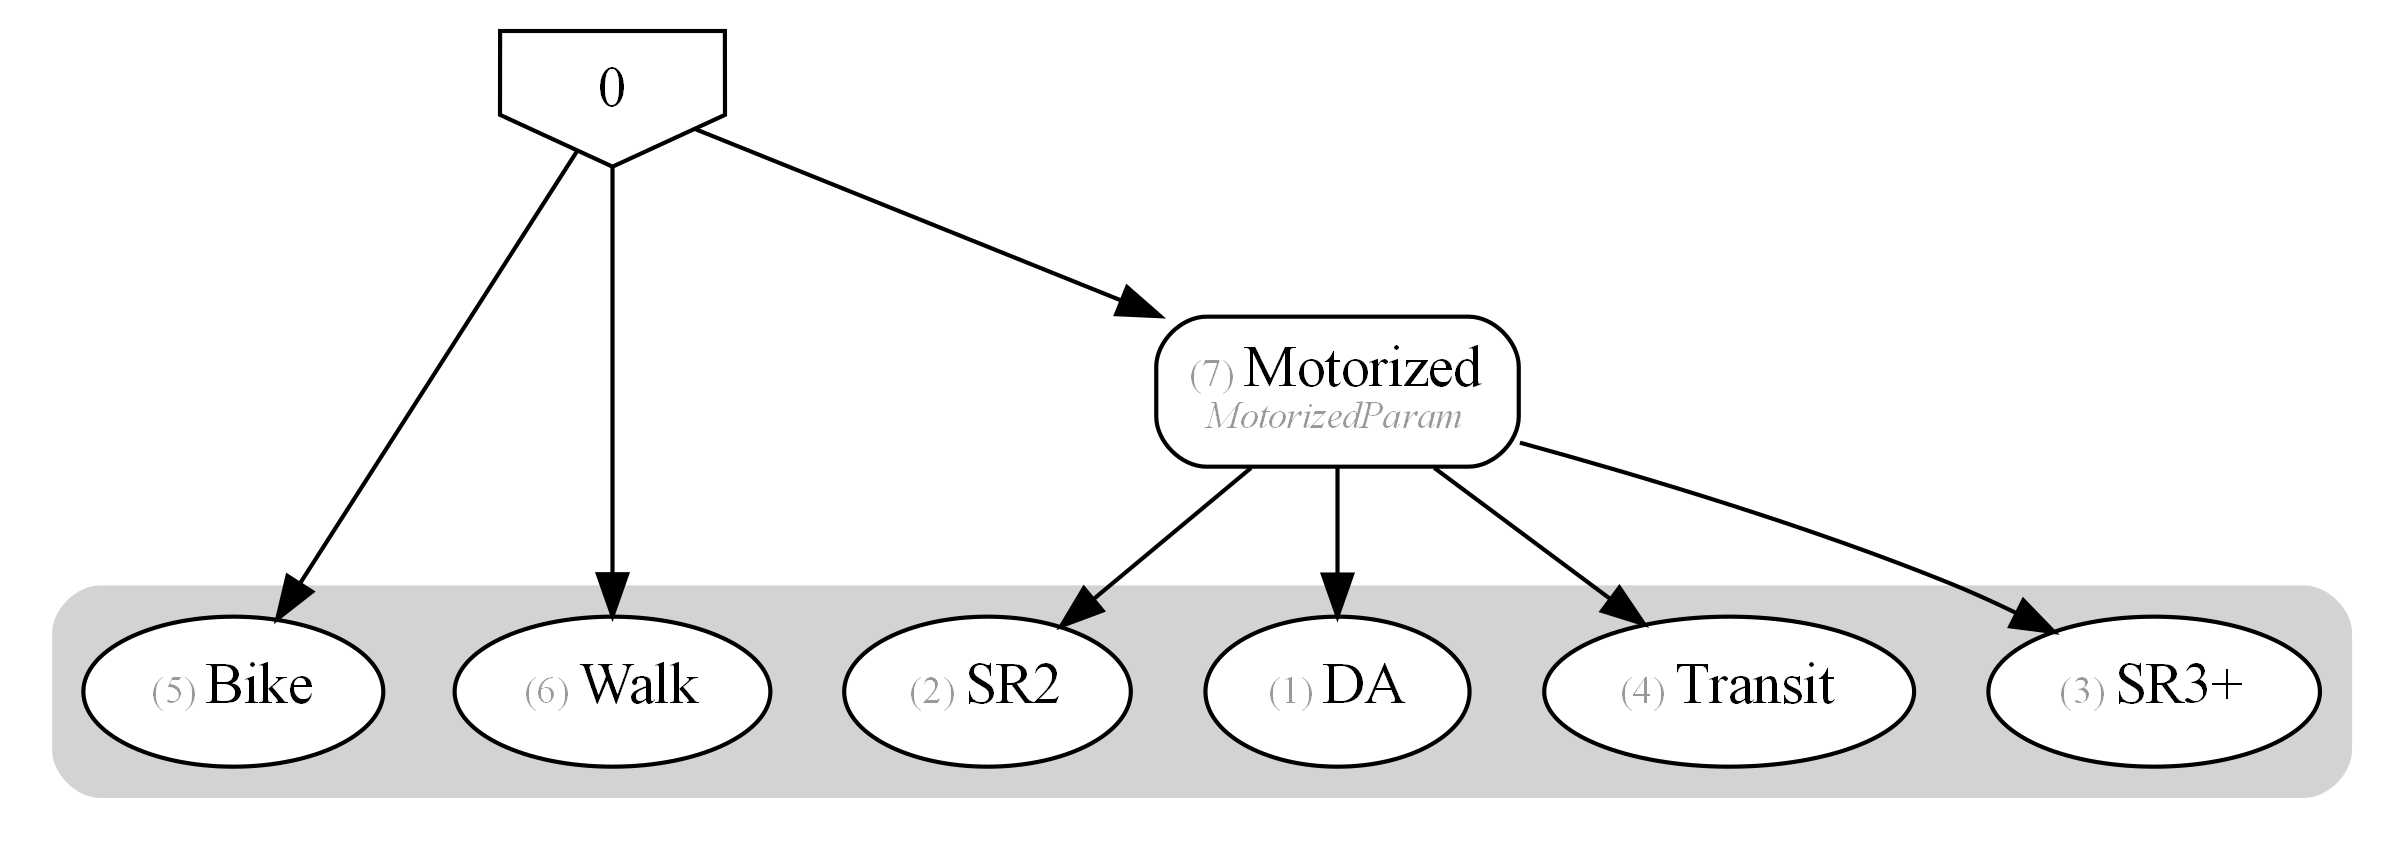

In [20]:
m[18].graph.to_png()

The PNG image can be saved to the file system with the argument `filename`, so you can easily get it out of the Jupyter notebook and into a Word, Excel, or other convenient document format.

In [21]:
m[18].graph.to_png(filename="./tmp/m18.png");

The `to_png` method also accepts a `figsize` argument, if we want to give the maximum width
and height of the output, in inches.  

<xmle.Elem 'img' with 0 children>
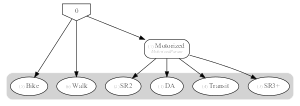

In [22]:
m[18].graph.to_png(figsize=(1,1))

You can make the output quite small, but the content doesn't dynamically scale with the figure size,
so if it's too small it will be totally illegible.

In [23]:
m[18].graph.to_png(figsize=(0.25,0.25))

<xmle.Elem 'img' with 0 children>

Let's estimate all the simple models listed above and compare the.

In [24]:
m[19] = m[17].copy()
m[19].set_values('null')
m[19].title = "Model 19"
m[19].graph.new_node(name="Automobile", parameter="Automobile", children=[1,2,3]);
m[19].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [25]:
m[20] = m[17].copy()
m[20].set_values('null')
m[20].title = "Model 20"
m[20].graph.new_node(name="SharedRide", parameter="SharedRide", children=[2,3]);
m[20].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [26]:
m[21] = m[17].copy()
m[21].set_values('null')
m[21].title = "Model 21"
m[21].graph.new_node(name="NonMotorized", parameter="NonMotorized", children=[5,6]);
m[21].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [27]:
# A helper function to create a small grid of images to show nests
from xmle import Elem
def table_of_images(content, ncols=2):
    col = 0
    t = Elem("table")            # Top level HTML table element
    tr = t.elem("tr")            # start a first <tr> table row
    cell_css = 'text-align:center;font-weight:bold;background-color:white' # formatting
    for k,v in content.items():  # Loop over title/image content of table
        cell = tr.elem("td", style=cell_css, text=k) # start a <td> table data cell
        cell.append(v)           # add the content
        col += 1                 # move to next column
        if col == ncols:         # or if we were in the last column
            tr = t.elem("tr")    # start a new <tr> table row
            col = 0              # and move back to the first column
    return t
            

#### Nesting Tree Figures

Model 18,Model 19
Model 20,Model 21

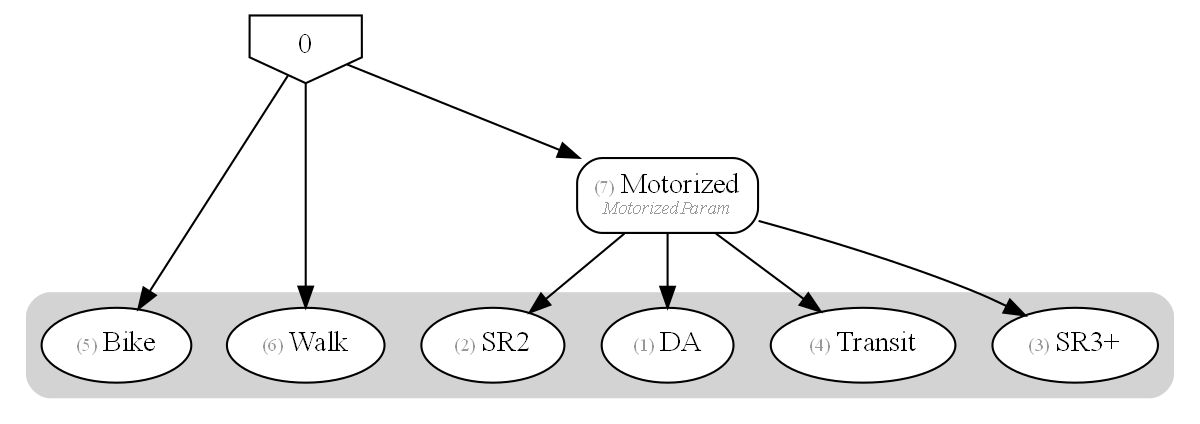
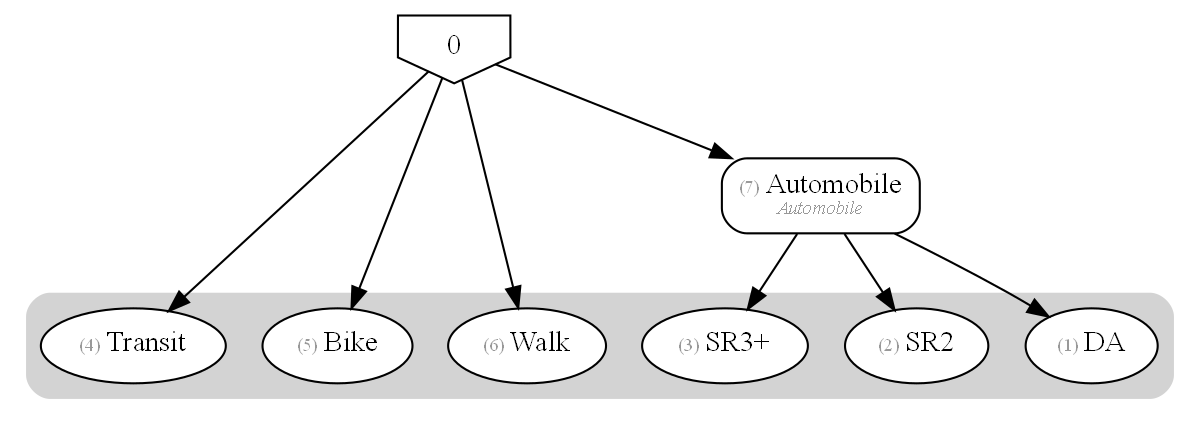
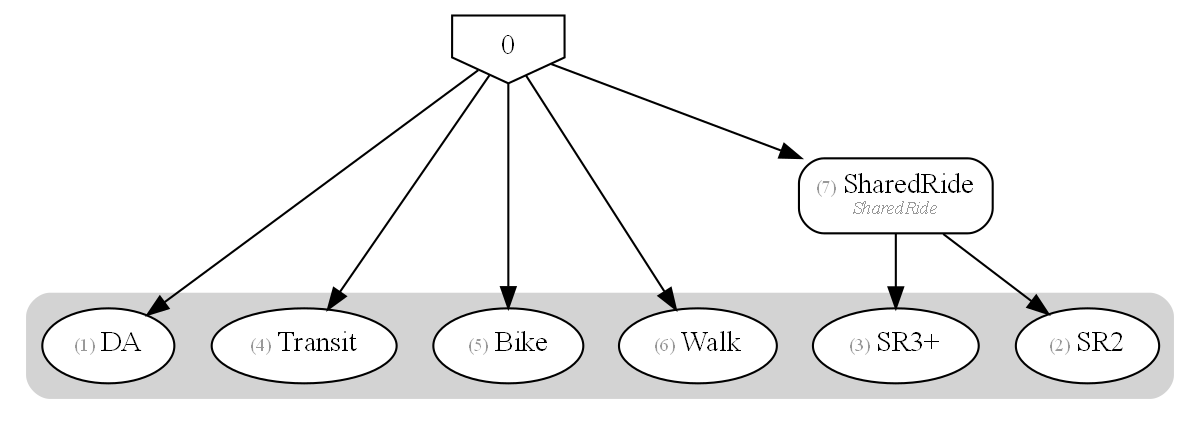
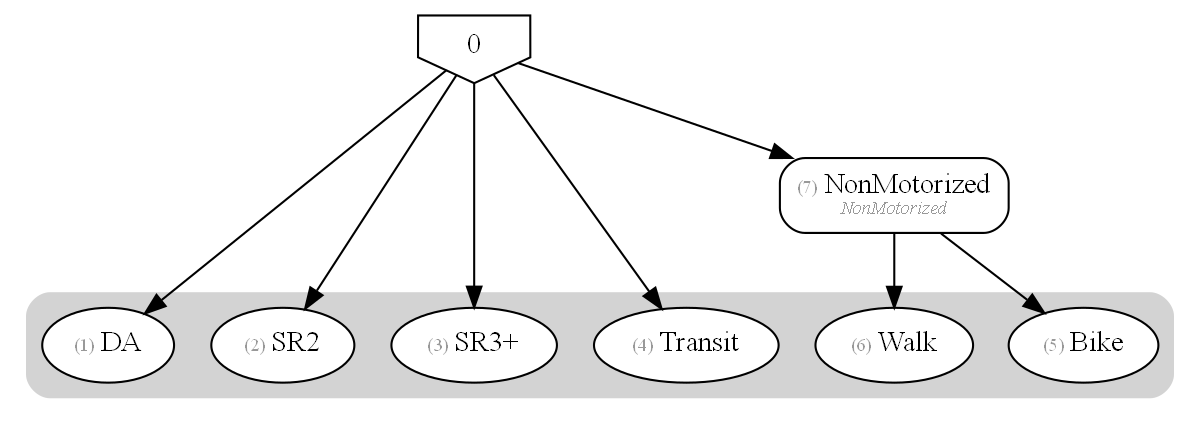

In [28]:
table_of_images({
    f'Model {n}':m[n].graph.to_png(figsize=(4,3), filename=f'./tmp/model_{n}.png') 
    for n in (18,19,20,21)
})

#### Table of Results

In [29]:
from larch.util.summary import joint_parameter_summary

joint_parameter_summary(
    [m[i] for i in (17,18,19,20,21)], 
    ordering=m[17].ordering,
    bases=[m_c,]
)

Model 17           Model 18          \
                                      Param  t-Stat      Param  t-Stat   
Category       Parameter                                                 
LoS            totcost/hhinc        -0.0524   -5.04    -0.0524   -5.04   
               motor_time           -0.0202   -5.29    -0.0202   -5.29   
               nonmotor_time        -0.0454   -7.88    -0.0454   -7.88   
               ovtt/dist             -0.133   -6.76     -0.133   -6.76   
HH             hhinc#4             -0.00532   -2.69   -0.00532   -2.69   
               hhinc#5             -0.00864   -1.68   -0.00864   -1.68   
               hhinc#6             -0.00599   -1.90   -0.00600   -1.90   
               numveh#23             -0.317   -4.75     -0.317   -4.75   
               numveh#4              -0.947   -8.00     -0.947   -8.00   
               numveh#5              -0.703   -2.72     -0.702   -2.72   
               numveh#6              -0.723   -4.26     -0.722   -4.26   
Zone           wkempden#2           0.00158    4.04    0.00158    4.04   
               wkempden#3           0.00226    4.99    0.00226    4.99   
               wkempden#4           0.00313    8.68    0.00313    8.68   
               wkempden#5           0.00193    1.59    0.00193    1.59   
               wkempden#6           0.00289    3.90    0.00289    3.89   
               wkccbd#2               0.260    2.11      0.260    2.11   
               wkccbd#3                1.07    5.59       1.07    5.59   
               wkccbd#4                1.31    7.90       1.31    7.90   
               wkccbd#5               0.489    1.35      0.489    1.35   
               wkccbd#6               0.102    0.40      0.102    0.40   
ASCs           ASC_BIKE               -1.63   -3.81      -1.63   -3.81   
               ASC_SR2                -1.81  -17.03      -1.81  -17.03   
               ASC_SR3P               -3.43  -22.61      -3.43  -22.61   
               ASC_TRAN              -0.684   -2.76     -0.684   -2.76   
               ASC_WALK              0.0688    0.20     0.0690    0.20   
Other          Automobile                                                
               NonMotorized                                              
               SharedRide                                                
----           ----                    ----    ----       ----    ----   
Log Likelihood Converged          -3,444.14          -3,444.14           
               Null               -7,309.60          -7,309.60           
               Constants Only     -4,132.92          -4,132.92           
Rho Squared    vs Null               0.5288             0.5288           
               vs Constants Only     0.1667             0.1667           

                                   Model 19           Model 20          \
                                      Param  t-Stat      Param  t-Stat   
Category       Parameter                                                 
LoS            totcost/hhinc        -0.0524   -5.04    -0.0455   -4.25   
               motor_time           -0.0202   -5.29    -0.0206   -5.65   
               nonmotor_time        -0.0454   -7.88    -0.0452   -7.85   
               ovtt/dist             -0.133   -6.76     -0.134   -6.81   
HH             hhinc#4             -0.00532   -2.69   -0.00541   -2.74   
               hhinc#5             -0.00864   -1.68   -0.00890   -1.72   
               hhinc#6             -0.00600   -1.90   -0.00623   -1.97   
               numveh#23             -0.317   -4.75     -0.315   -4.73   
               numveh#4              -0.947   -8.00     -0.938   -7.95   
               numveh#5              -0.702   -2.72     -0.703   -2.72   
               numveh#6              -0.722   -4.26     -0.725   -4.28   
Zone           wkempden#2           0.00158    4.04    0.00188    5.35   
               wkempden#3           0.00226    4.99    0.00192    5.36   
               wkempden#4           0.

In [30]:
value_of_time(m[17])

,% Wage Rate,$10/hr,$20/hr,$40/hr
Non-Motor,104.04%,$10.40/hr,$20.81/hr,$41.62/hr
IVTT,46.22%,$4.62/hr,$9.24/hr,$18.49/hr
OVTT @ 1 mile,350.34%,$35.03/hr,$70.07/hr,$140.14/hr
OVTT @ 5 mile,107.05%,$10.70/hr,$21.41/hr,$42.82/hr
OVTT @ 10 mile,76.64%,$7.66/hr,$15.33/hr,$30.65/hr


In [31]:
pd.DataFrame({
    m[i].title: value_of_time(m[i]).stack() 
    for i in (17,18,19,20,21)
})

Model 17    Model 18    Model 19    Model 20  \
Non-Motor      % Wage Rate     104.04%     104.04%     104.04%     119.22%   
               $10/hr        $10.40/hr   $10.40/hr   $10.40/hr   $11.92/hr   
               $20/hr        $20.81/hr   $20.81/hr   $20.81/hr   $23.84/hr   
               $40/hr        $41.62/hr   $41.62/hr   $41.62/hr   $47.69/hr   
IVTT           % Wage Rate      46.22%      46.22%      46.22%      54.22%   
               $10/hr         $4.62/hr    $4.62/hr    $4.62/hr    $5.42/hr   
               $20/hr         $9.24/hr    $9.24/hr    $9.24/hr   $10.84/hr   
               $40/hr        $18.49/hr   $18.49/hr   $18.49/hr   $21.69/hr   
OVTT @ 1 mile  % Wage Rate     350.34%     350.38%     350.37%     406.90%   
               $10/hr        $35.03/hr   $35.04/hr   $35.04/hr   $40.69/hr   
               $20/hr        $70.07/hr   $70.08/hr   $70.07/hr   $81.38/hr   
               $40/hr       $140.14/hr  $140.15/hr  $140.15/hr  $162.76/hr   
OVTT @ 5 mile  % Wage Rate     107.05%     107.05%     107.05%     124.76%   
               $10/hr        $10.70/hr   $10.71/hr   $10.70/hr   $12.48/hr   
               $20/hr        $21.41/hr   $21.41/hr   $21.41/hr   $24.95/hr   
               $40/hr        $42.82/hr   $42.82/hr   $42.82/hr   $49.90/hr   
OVTT @ 10 mile % Wage Rate      76.64%      76.64%      76.63%      89.49%   
               $10/hr         $7.66/hr    $7.66/hr    $7.66/hr    $8.95/hr   
               $20/hr        $15.33/hr   $15.33/hr   $15.33/hr   $17.90/hr   
               $40/hr        $30.65/hr   $30.65/hr   $30.65/hr   $35.79/hr   

                              Model 21  
Non-Motor      % Wage Rate     104.89%  
               $10/hr        $10.49/hr  
               $20/hr        $20.98/hr  
               $40/hr        $41.96/hr  
IVTT           % Wage Rate      46.02%  
               $10/hr         $4.60/hr  
               $20/hr         $9.20/hr  
               $40/hr        $18.41/hr  
OVTT @ 1 mile  % Wage Rate     358.28%  
               $10/hr        $35.83/hr  
               $20/hr        $71.66/hr  
               $40/hr       $143.31/hr  
OVTT @ 5 mile  % Wage Rate     108.47%  
               $10/hr        $10.85/hr  
               $20/hr        $21.69/hr  
               $40/hr        $43.39/hr  
OVTT @ 10 mile % Wage Rate      77.24%  
               $10/hr         $7.72/hr  
               $20/hr        $15.45/hr  
               $40/hr        $30.90/hr

#### Hypothesis Testing

In [32]:
from scipy.stats import chi2

def LRT(model_u, model_r, deg_free):
    stat = 2*(model_u.loglike() - model_r.loglike())
    p = chi2(df=deg_free).sf(stat)
    return f"{stat:.3f}, p={p:.3f}, df={deg_free}"

In [33]:
for i in (18,19,20,21):
    print(m[i].title,"vs",m[17].title,": Chi-Sq=",LRT(m[i], m[17], 1))

Model 18 vs Model 17 : Chi-Sq= 0.000, p=0.998, df=1
Model 19 vs Model 17 : Chi-Sq= 0.000, p=0.998, df=1
Model 20 vs Model 17 : Chi-Sq= 3.541, p=0.060, df=1
Model 21 vs Model 17 : Chi-Sq= 1.261, p=0.261, df=1


### Two Nests for Different Groups

In [34]:
m[22] = m[17].copy()
m[22].set_values('null')
m[22].title = "Model 22"
m[22].graph.new_node(name="Motorized", parameter="Motorized", children=[1,2,3,4]);
m[22].graph.new_node(name="NonMotorized", parameter="NonMotorized", children=[5,6]);
m[22].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [35]:
m[23] = m[17].copy()
m[23].set_values('null')
m[23].title = "Model 23"
m[23].graph.new_node(name="Automobile", parameter="Automobile", children=[1,2,3]);
m[23].graph.new_node(name="NonMotorized", parameter="NonMotorized", children=[5,6]);
m[23].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [36]:
m[24] = m[17].copy()
m[24].set_values('null')
m[24].title = "Model 24"
m[24].graph.new_node(name="SharedRide", parameter="SharedRide", children=[2,3]);
m[24].graph.new_node(name="NonMotorized", parameter="NonMotorized", children=[5,6]);
m[24].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


#### Nesting Tree Figures

<xmle.Elem 'table' with 2 children>
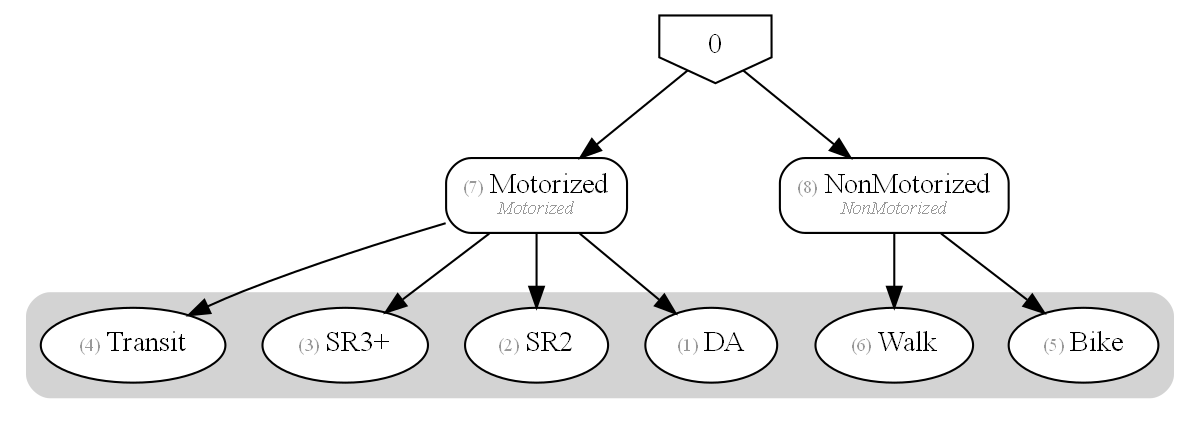
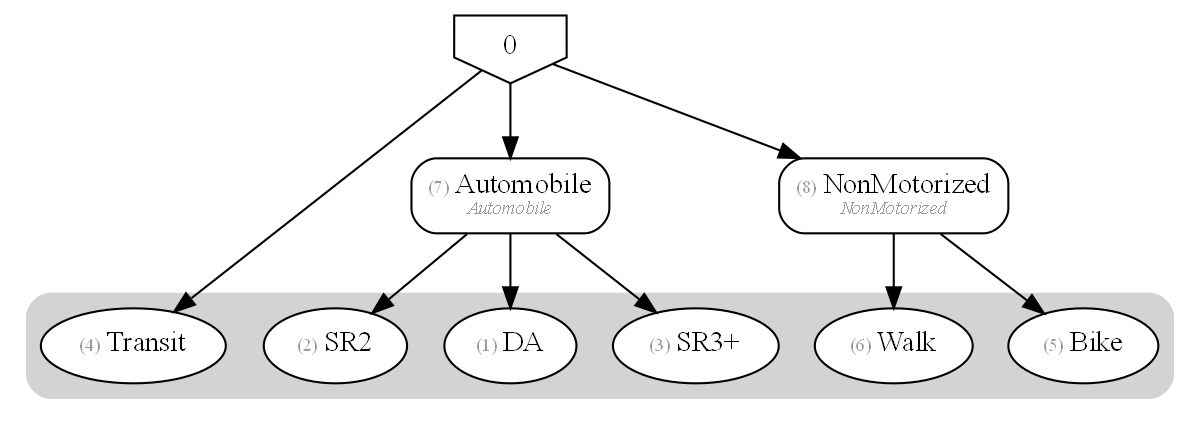
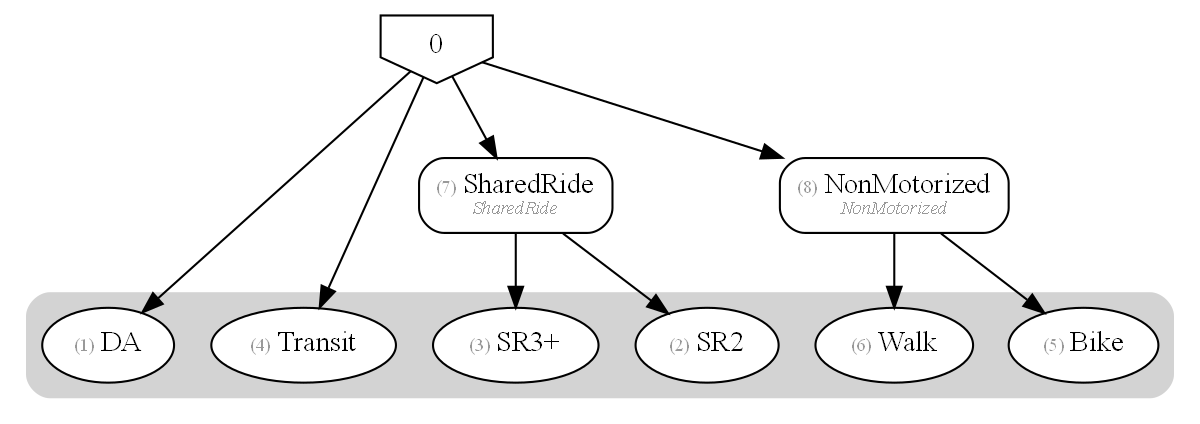

In [37]:
table_of_images({f'Model {n}':m[n].graph.to_png(figsize=(4,3)) for n in (22,23,24)})

#### Table of Results

In [38]:
joint_parameter_summary([m[i] for i in (17,22,23,24)], ordering=m[17].ordering)

Model 17           Model 22          Model 23  \
                                  Param  t-Stat      Param t-Stat      Param   
Category       Parameter                                                       
LoS            totcost/hhinc    -0.0524   -5.04    -0.0386  -3.72    -0.0519   
               motor_time       -0.0202   -5.29    -0.0145  -3.76    -0.0199   
               nonmotor_time    -0.0454   -7.88    -0.0462  -8.56    -0.0454   
               ovtt/dist         -0.133   -6.76     -0.114  -5.39     -0.135   
HH             hhinc#4         -0.00532   -2.69   -0.00393  -2.44   -0.00534   
               hhinc#5         -0.00864   -1.68    -0.0100  -2.16   -0.00922   
               hhinc#6         -0.00599   -1.90   -0.00621  -2.05   -0.00560   
               numveh#23         -0.317   -4.75     -0.226  -3.47     -0.317   
               numveh#4          -0.947   -8.00     -0.707  -4.72     -0.947   
               numveh#5          -0.703   -2.72     -0.735  -3.21     -0.693   
               numveh#6          -0.723   -4.26     -0.765  -4.68     -0.715   
Zone           wkempden#2       0.00158    4.04    0.00115   3.24    0.00158   
               wkempden#3       0.00226    4.99    0.00164   3.65    0.00226   
               wkempden#4       0.00313    8.68    0.00224   4.41    0.00314   
               wkempden#5       0.00193    1.59    0.00167   1.54    0.00219   
               wkempden#6       0.00289    3.90    0.00217   2.85    0.00279   
               wkccbd#2           0.260    2.11      0.193   2.01      0.260   
               wkccbd#3            1.07    5.59      0.781   3.91       1.07   
               wkccbd#4            1.31    7.90      0.921   4.15       1.31   
               wkccbd#5           0.489    1.35      0.408   1.24      0.414   
               wkccbd#6           0.102    0.40      0.114   0.48      0.103   
ASCs           ASC_BIKE           -1.63   -3.81      -1.20  -2.88      -1.45   
               ASC_SR2            -1.81  -17.03      -1.32  -5.20      -1.81   
               ASC_SR3P           -3.43  -22.61      -2.50  -5.27      -3.43   
               ASC_TRAN          -0.684   -2.76     -0.403  -1.82     -0.681   
               ASC_WALK          0.0688    0.20      0.346   0.97     0.0796   
Other          Automobile                                               1.00   
               Motorized                             0.726  -2.03              
               NonMotorized                          0.769  -1.29      0.766   
               SharedRide                                                      
----           ----                ----    ----       ----   ----       ----   
Log Likelihood Converged      -3,444.14          -3,441.63         -3,443.51   
               Null           -7,309.60          -7,309.60         -7,309.60   
Rho Squared    vs Null           0.5288             0.5292            0.5289   

                                       Model 24          
                              t-Stat      Param  t-Stat  
Category       Parameter                                 
LoS            totcost/hhinc   -4.99    -0.0450   -4.20  
               motor_time      -5.22    -0.0203   -5.58  
               nonmotor_time   -8.25    -0.0452   -8.23  
               ovtt/dist       -6.82     -0.136   -6.87  
HH             hhinc#4         -2.70   -0.00543   -2.75  
               hhinc#5         -2.00   -0.00949   -2.06  
               hhinc#6         -1.85   -0.00583   -1.92  
               numveh#23       -4.75     -0.315   -4.73  
               numveh#4        -8.01     -0.939   -7.96  
               numveh#5        -3.08     -0.694   -3.09  
               numveh#6        -4.40     -0.717   -4.41  
Zone           wkempden#2       4.05    0.00188    5.36  
               wkempden#3       5.01    0.00192    5.38  
               wkempden#4       8.69    0.00322    8.84  
               wkempden#5       2.03    0.00229    2.12  
               wkempden#6 

In [39]:
pd.DataFrame({
    m[i].title: value_of_time(m[i]).stack() 
    for i in (17,22,23,24)
})

Model 17    Model 22    Model 23    Model 24
Non-Motor      % Wage Rate     104.04%     143.66%     104.89%     120.55%
               $10/hr        $10.40/hr   $14.37/hr   $10.49/hr   $12.05/hr
               $20/hr        $20.81/hr   $28.73/hr   $20.98/hr   $24.11/hr
               $40/hr        $41.62/hr   $57.47/hr   $41.96/hr   $48.22/hr
IVTT           % Wage Rate      46.22%      45.14%      46.02%      54.19%
               $10/hr         $4.62/hr    $4.51/hr    $4.60/hr    $5.42/hr
               $20/hr         $9.24/hr    $9.03/hr    $9.20/hr   $10.84/hr
               $40/hr        $18.49/hr   $18.06/hr   $18.41/hr   $21.68/hr
OVTT @ 1 mile  % Wage Rate     350.34%     398.79%     358.28%     417.44%
               $10/hr        $35.03/hr   $39.88/hr   $35.83/hr   $41.74/hr
               $20/hr        $70.07/hr   $79.76/hr   $71.66/hr   $83.49/hr
               $40/hr       $140.14/hr  $159.51/hr  $143.31/hr  $166.97/hr
OVTT @ 5 mile  % Wage Rate     107.05%     115.87%     108.47%     126.84%
               $10/hr        $10.70/hr   $11.59/hr   $10.85/hr   $12.68/hr
               $20/hr        $21.41/hr   $23.17/hr   $21.69/hr   $25.37/hr
               $40/hr        $42.82/hr   $46.35/hr   $43.39/hr   $50.74/hr
OVTT @ 10 mile % Wage Rate      76.64%      80.50%      77.24%      90.51%
               $10/hr         $7.66/hr    $8.05/hr    $7.72/hr    $9.05/hr
               $20/hr        $15.33/hr   $16.10/hr   $15.45/hr   $18.10/hr
               $40/hr        $30.65/hr   $32.20/hr   $30.90/hr   $36.21/hr

#### Hypothesis Testing

In [40]:
for i in (22,23,24):
    print(m[i].title,"vs",m[17].title,": Chi-Sq=",LRT(m[i], m[17], 1))

Model 22 vs Model 17 : Chi-Sq= 5.029, p=0.025, df=1
Model 23 vs Model 17 : Chi-Sq= 1.261, p=0.261, df=1
Model 24 vs Model 17 : Chi-Sq= 4.848, p=0.028, df=1


### Hierarchical Nests

In [41]:
m[25] = m[17].copy()
m[25].set_values('null')
m[25].title = "Model 25"
auto = m[25].graph.new_node(name="Automobile", parameter="Automobile", children=[1,2,3]);
m[25].graph.new_node(name="Motorized", parameter="Motorized", children=[auto, 4]);
m[25].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [42]:
m[26] = m[17].copy()
m[26].set_values('null')
m[26].title = "Model 26"
sr = m[26].graph.new_node(name="SharedRide", parameter="SharedRide", children=[2,3]);
m[26].graph.new_node(name="Motorized", parameter="Motorized", children=[1, sr, 4]);
m[26].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [43]:
m[27] = m[17].copy()
m[27].set_values('null')
m[27].title = "Model 27"
sr = m[27].graph.new_node(name="SharedRide", parameter="SharedRide", children=[2,3]);
m[27].graph.new_node(name="Automobile", parameter="Automobile", children=[1, sr]);
m[27].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


#### Nesting Tree Figures

<xmle.Elem 'table' with 2 children>
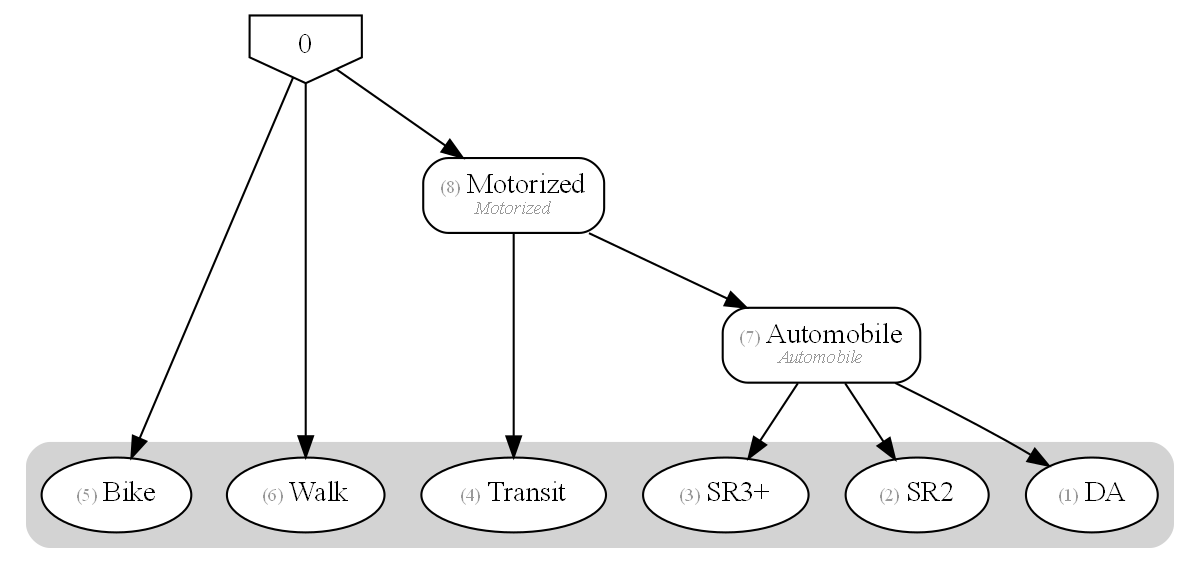
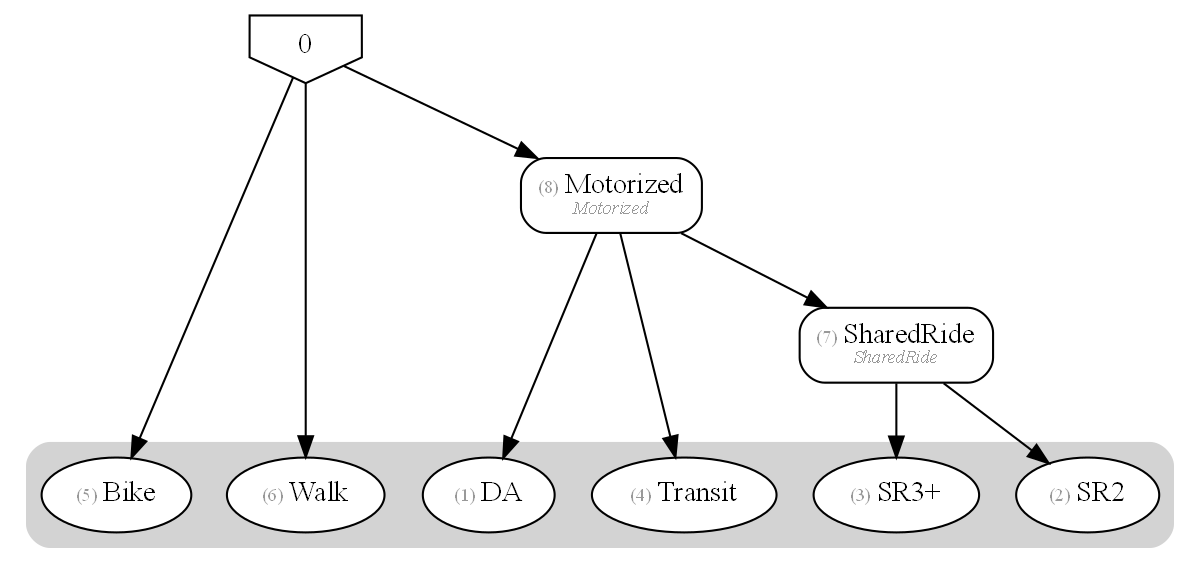
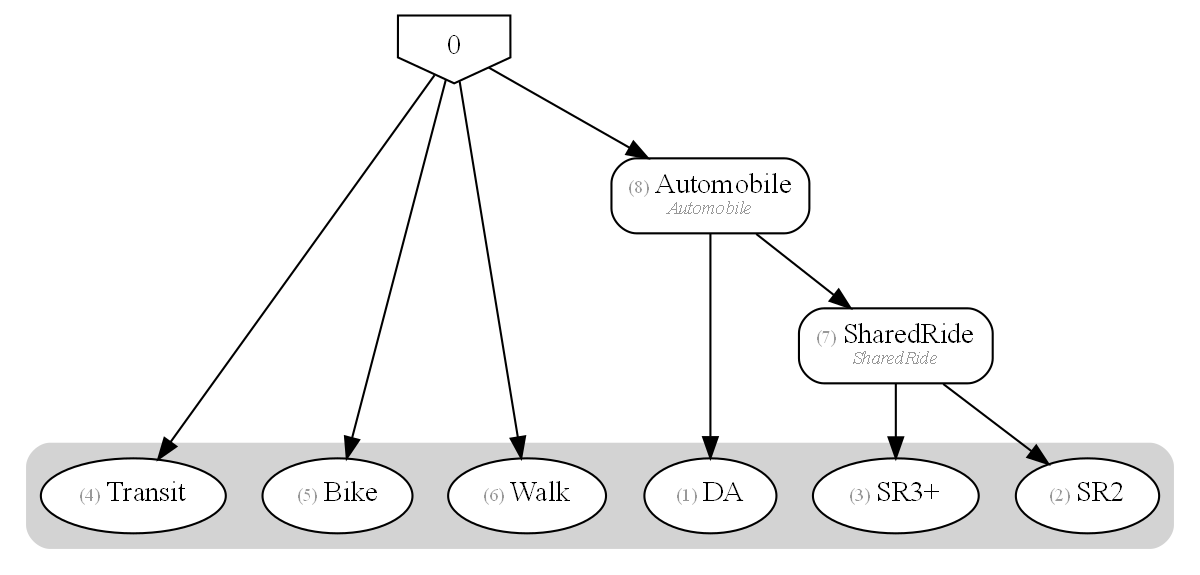

In [44]:
table_of_images({f'Model {n}':m[n].graph.to_png(figsize=(4,3)) for n in (25,26,27)})

#### Table of Results

In [45]:
joint_parameter_summary([m[i] for i in (17,25,26,27)], ordering=m[17].ordering)

Model 17           Model 25          Model 26  \
                                  Param  t-Stat      Param t-Stat      Param   
Category       Parameter                                                       
LoS            totcost/hhinc    -0.0524   -5.04    -0.0363  -3.81    -0.0336   
               motor_time       -0.0202   -5.29    -0.0106  -3.68    -0.0149   
               nonmotor_time    -0.0454   -7.88    -0.0471  -8.41    -0.0461   
               ovtt/dist         -0.133   -6.76    -0.0995  -5.43     -0.113   
HH             hhinc#4         -0.00532   -2.69   -0.00215  -1.84   -0.00400   
               hhinc#5         -0.00864   -1.68   -0.00905  -1.74   -0.00969   
               hhinc#6         -0.00599   -1.90   -0.00609  -1.95   -0.00677   
               numveh#23         -0.317   -4.75     -0.322  -3.78     -0.224   
               numveh#4          -0.947   -8.00     -0.463  -4.36     -0.700   
               numveh#5          -0.703   -2.72     -0.689  -2.66     -0.743   
               numveh#6          -0.723   -4.26     -0.706  -4.17     -0.774   
Zone           wkempden#2       0.00158    4.04    0.00158   3.54    0.00136   
               wkempden#3       0.00226    4.99    0.00235   4.06    0.00139   
               wkempden#4       0.00313    8.68    0.00194   4.61    0.00230   
               wkempden#5       0.00193    1.59    0.00142   1.18    0.00151   
               wkempden#6       0.00289    3.90    0.00219   2.91    0.00233   
               wkccbd#2           0.260    2.11      0.275   2.32      0.291   
               wkccbd#3            1.07    5.59       1.03   4.16      0.471   
               wkccbd#4            1.31    7.90      0.731   4.44      0.927   
               wkccbd#5           0.489    1.35      0.500   1.40      0.486   
               wkccbd#6           0.102    0.40      0.142   0.58      0.122   
ASCs           ASC_BIKE           -1.63   -3.81      -1.38  -3.11      -1.38   
               ASC_SR2            -1.81  -17.03      -1.63  -5.73      -1.23   
               ASC_SR3P           -3.43  -22.61      -3.15  -5.75      -1.62   
               ASC_TRAN          -0.684   -2.76     -0.407  -2.37     -0.401   
               ASC_WALK          0.0688    0.20      0.340   0.94      0.337   
Other          Automobile                            0.923  -0.48              
               Motorized                             0.532  -4.95      0.725   
               SharedRide                                              0.242   
----           ----                ----    ----       ----   ----       ----   
Log Likelihood Converged      -3,444.14          -3,427.13         -3,440.56   
               Null           -7,309.60          -7,309.60         -7,309.60   
Rho Squared    vs Null           0.5288             0.5311            0.5293   

                                      Model 27          
                             t-Stat      Param  t-Stat  
Category       Parameter                                
LoS            totcost/hhinc  -3.31    -0.0455   -4.25  
               motor_time     -3.84    -0.0206   -5.65  
               nonmotor_time  -8.15    -0.0452   -7.85  
               ovtt/dist      -5.39     -0.134   -6.81  
HH             hhinc#4        -2.47   -0.00542   -2.74  
               hhinc#5        -1.86   -0.00890   -1.72  
               hhinc#6        -2.15   -0.00623   -1.97  
               numveh#23      -3.43     -0.315   -4.73  
               numveh#4       -4.65     -0.939   -7.95  
               numveh#5       -2.82     -0.703   -2.72  
               numveh#6       -4.54     -0.725   -4.28  
Zone           wkempden#2      3.76    0.00188    5.35  
               wkempden#3      3.77    0.00192    5.36  
               wkempden#4      4.38    0.00322    8.83  
               wkempden#5      1.24    0.00202    1.66  
               wkempden#6      3.00    0.00297    4.00  
               wkccbd#2        2.95      0.396    3.48  
          

In [46]:
pd.DataFrame({
    m[i].title: value_of_time(m[i]).stack() 
    for i in (17,25,26,27)
})

Model 17    Model 25    Model 26    Model 27
Non-Motor      % Wage Rate     104.04%     155.64%     164.51%     119.22%
               $10/hr        $10.40/hr   $15.56/hr   $16.45/hr   $11.92/hr
               $20/hr        $20.81/hr   $31.13/hr   $32.90/hr   $23.84/hr
               $40/hr        $41.62/hr   $62.26/hr   $65.80/hr   $47.69/hr
IVTT           % Wage Rate      46.22%      34.92%      53.35%      54.22%
               $10/hr         $4.62/hr    $3.49/hr    $5.33/hr    $5.42/hr
               $20/hr         $9.24/hr    $6.98/hr   $10.67/hr   $10.84/hr
               $40/hr        $18.49/hr   $13.97/hr   $21.34/hr   $21.69/hr
OVTT @ 1 mile  % Wage Rate     350.34%     363.68%     456.85%     406.90%
               $10/hr        $35.03/hr   $36.37/hr   $45.69/hr   $40.69/hr
               $20/hr        $70.07/hr   $72.74/hr   $91.37/hr   $81.38/hr
               $40/hr       $140.14/hr  $145.47/hr  $182.74/hr  $162.76/hr
OVTT @ 5 mile  % Wage Rate     107.05%     100.67%     134.05%     124.76%
               $10/hr        $10.70/hr   $10.07/hr   $13.40/hr   $12.48/hr
               $20/hr        $21.41/hr   $20.13/hr   $26.81/hr   $24.95/hr
               $40/hr        $42.82/hr   $40.27/hr   $53.62/hr   $49.90/hr
OVTT @ 10 mile % Wage Rate      76.64%      67.79%      93.70%      89.49%
               $10/hr         $7.66/hr    $6.78/hr    $9.37/hr    $8.95/hr
               $20/hr        $15.33/hr   $13.56/hr   $18.74/hr   $17.90/hr
               $40/hr        $30.65/hr   $27.12/hr   $37.48/hr   $35.79/hr

#### Hypothesis Testing

In [47]:
def LRT_2(i1,i2,df):
    print(m[i1].title,"vs",m[i2].title,": Chi-Sq=",LRT(m[i1], m[i2], df))

for i in (25,26,27):
    LRT_2(i,17,2)
    
LRT_2(25,19,1)
LRT_2(26,20,1)
# LRT_2(27,??,1)

Model 25 vs Model 17 : Chi-Sq= 34.032, p=0.000, df=2
Model 26 vs Model 17 : Chi-Sq= 7.173, p=0.028, df=2
Model 27 vs Model 17 : Chi-Sq= 3.541, p=0.170, df=2
Model 25 vs Model 19 : Chi-Sq= 34.032, p=0.000, df=1
Model 26 vs Model 20 : Chi-Sq= 3.631, p=0.057, df=1


### More Complex Nests

In [48]:
m[28] = m[17].copy()
m[28].set_values('null')
m[28].title = "Model 28"
sr = m[28].graph.new_node(name="SharedRide", parameter="SharedRide", children=[2,3])
m[28].graph.new_node(name="Motorized", parameter="Motorized", children=[1, sr, 4])
m[28].graph.new_node(name="NonMotorized", parameter="NonMotorized", children=[5,6])
m[28].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [49]:
m[29] = m[17].copy()
m[29].set_values('null')
m[29].title = "Model 29"
sr = m[29].graph.new_node(name="SharedRide", parameter="SharedRide", children=[2,3])
auto = m[29].graph.new_node(name="Automobile", parameter="Automobile", children=[1,sr])
m[29].graph.new_node(name="Motorized", parameter="Motorized", children=[auto, 4])
m[29].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


#### Nesting Tree Figures

Model 28,Model 29

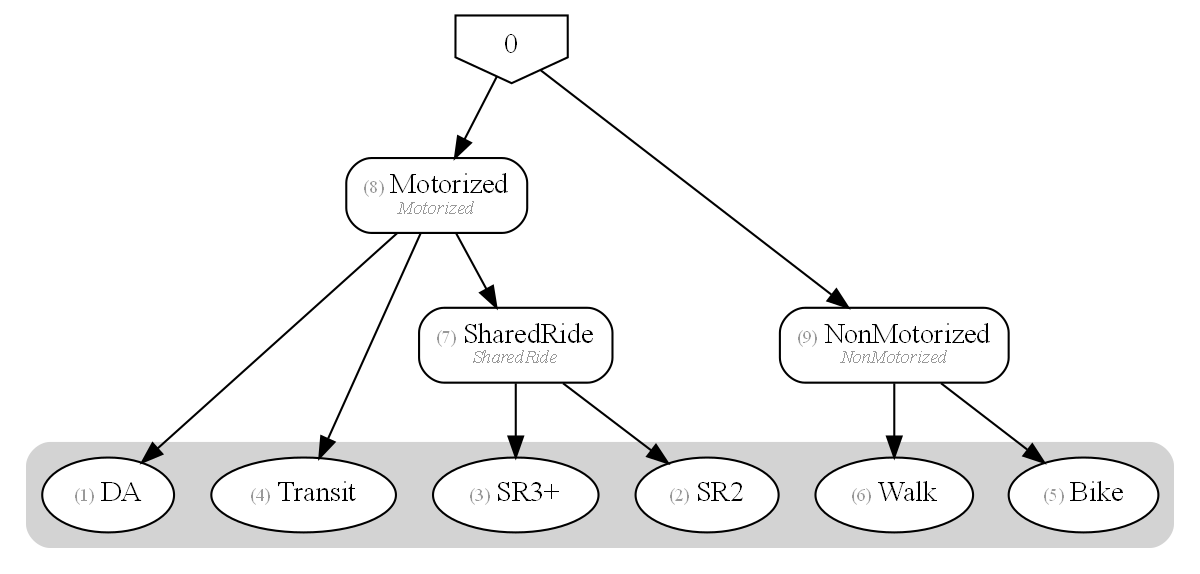
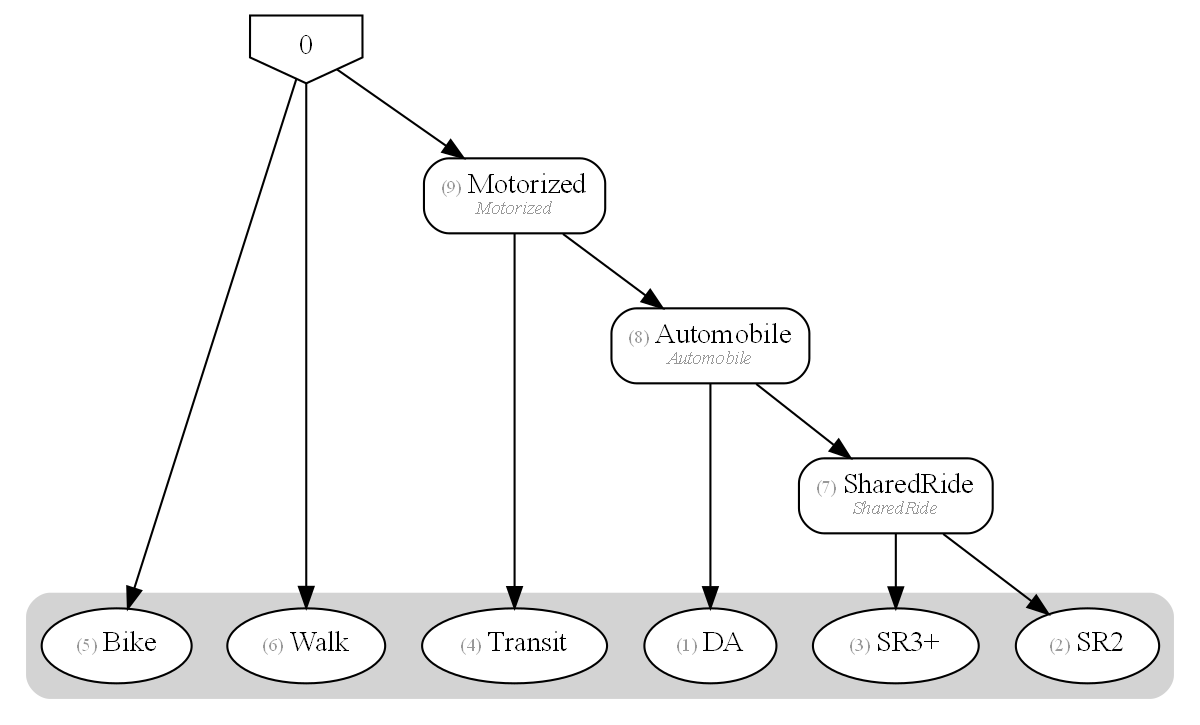

In [50]:
table_of_images({f'Model {n}':m[n].graph.to_png(figsize=(4,3)) for n in (28,29)})

#### Table of Results

In [51]:
joint_parameter_summary([m[i] for i in (17,28,29)], ordering=m[17].ordering)

Model 17           Model 28          Model 29  \
                                  Param  t-Stat      Param t-Stat      Param   
Category       Parameter                                                       
LoS            totcost/hhinc    -0.0524   -5.04    -0.0334  -3.32    -0.0316   
               motor_time       -0.0202   -5.29    -0.0149  -3.88    -0.0111   
               nonmotor_time    -0.0454   -7.88    -0.0460  -8.53    -0.0470   
               ovtt/dist         -0.133   -6.76     -0.115  -5.41     -0.100   
HH             hhinc#4         -0.00532   -2.69   -0.00402  -2.48   -0.00222   
               hhinc#5         -0.00864   -1.68    -0.0102  -2.20   -0.00920   
               hhinc#6         -0.00599   -1.90   -0.00638  -2.11   -0.00625   
               numveh#23         -0.317   -4.75     -0.225  -3.45     -0.323   
               numveh#4          -0.947   -8.00     -0.703  -4.69     -0.457   
               numveh#5          -0.703   -2.72     -0.736  -3.22     -0.689   
               numveh#6          -0.723   -4.26     -0.766  -4.69     -0.707   
Zone           wkempden#2       0.00158    4.04    0.00137   3.79    0.00191   
               wkempden#3       0.00226    4.99    0.00140   3.80    0.00195   
               wkempden#4       0.00313    8.68    0.00231   4.42    0.00199   
               wkempden#5       0.00193    1.59    0.00175   1.61    0.00148   
               wkempden#6       0.00289    3.90    0.00224   2.91    0.00225   
               wkccbd#2           0.260    2.11      0.293   2.96      0.416   
               wkccbd#3            1.07    5.59      0.472   3.48      0.578   
               wkccbd#4            1.31    7.90      0.930   4.15      0.737   
               wkccbd#5           0.489    1.35      0.415   1.27      0.508   
               wkccbd#6           0.102    0.40      0.123   0.52      0.150   
ASCs           ASC_BIKE           -1.63   -3.81      -1.19  -2.87      -1.38   
               ASC_SR2            -1.81  -17.03      -1.24  -5.14      -1.51   
               ASC_SR3P           -3.43  -22.61      -1.62  -4.57      -1.86   
               ASC_TRAN          -0.684   -2.76     -0.400  -1.81     -0.396   
               ASC_WALK          0.0688    0.20      0.348   0.97      0.341   
Other          Automobile                                              0.928   
               Motorized                             0.728  -2.00      0.533   
               NonMotorized                          0.766  -1.31              
               SharedRide                            0.241  -7.24      0.217   
----           ----                ----    ----       ----   ----       ----   
Log Likelihood Converged      -3,444.14          -3,439.90         -3,425.12   
               Null           -7,309.60          -7,309.60         -7,309.60   
Rho Squared    vs Null           0.5288             0.5294            0.5314   

                                     
                             t-Stat  
Category       Parameter             
LoS            totcost/hhinc  -3.36  
               motor_time     -3.86  
               nonmotor_time  -8.39  
               ovtt/dist      -5.44  
HH             hhinc#4        -1.89  
               hhinc#5        -1.77  
               hhinc#6        -2.00  
               numveh#23      -3.77  
               numveh#4       -4.33  
               numveh#5       -2.66  
               numveh#6       -4.18  
Zone           wkempden#2      4.20  
               wkempden#3      4.24  
               wkempden#4      4.63  
               wkempden#5      1.23  
               wkempden#6      2.97  
               wkccbd#2        3.44  
               wkccbd#3        3.84  
               wkccbd#4        4.44  
               wkccbd#5        1.42  
               wkccbd#6        0.62  
ASCs           ASC_BIKE       -3.11  
               ASC_SR2        -5.69  
               ASC_SR3P       -5.12  
               ASC_TRAN       -2.33  
      

In [52]:
pd.DataFrame({
    m[i].title: value_of_time(m[i]).stack() 
    for i in (17,28,29)
})

Model 17    Model 28    Model 29
Non-Motor      % Wage Rate     104.04%     165.29%     178.08%
               $10/hr        $10.40/hr   $16.53/hr   $17.81/hr
               $20/hr        $20.81/hr   $33.06/hr   $35.62/hr
               $40/hr        $41.62/hr   $66.12/hr   $71.23/hr
IVTT           % Wage Rate      46.22%      53.32%      41.94%
               $10/hr         $4.62/hr    $5.33/hr    $4.19/hr
               $20/hr         $9.24/hr   $10.66/hr    $8.39/hr
               $40/hr        $18.49/hr   $21.33/hr   $16.77/hr
OVTT @ 1 mile  % Wage Rate     350.34%     465.45%     422.43%
               $10/hr        $35.03/hr   $46.55/hr   $42.24/hr
               $20/hr        $70.07/hr   $93.09/hr   $84.49/hr
               $40/hr       $140.14/hr  $186.18/hr  $168.97/hr
OVTT @ 5 mile  % Wage Rate     107.05%     135.75%     118.03%
               $10/hr        $10.70/hr   $13.58/hr   $11.80/hr
               $20/hr        $21.41/hr   $27.15/hr   $23.61/hr
               $40/hr        $42.82/hr   $54.30/hr   $47.21/hr
OVTT @ 10 mile % Wage Rate      76.64%      94.54%      79.98%
               $10/hr         $7.66/hr    $9.45/hr    $8.00/hr
               $20/hr        $15.33/hr   $18.91/hr   $16.00/hr
               $40/hr        $30.65/hr   $37.82/hr   $31.99/hr

### Fixing Some Issues

In [53]:
m[30] = m[17].copy()
m[30].set_values('null')
m[30].title = "Model 30"
sr = m[30].graph.new_node(name="SharedRide", parameter="SharedRide", children=[2,3])
auto = m[30].graph.new_node(name="Automobile", parameter="Automobile", children=[1,sr])
m[30].graph.new_node(name="Motorized", parameter="Motorized", children=[auto, 4])
m[30].lock_value('Automobile', 0.6)
m[30].lock_value('Motorized', 0.8)
m[30].estimate();

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


,value,initvalue,nullvalue,minimum,maximum,holdfast,note,std_err,t_stat,robust_std_err,robust_t_stat,best
ASC_BIKE,-1.327116,0.0,0.0,-inf,inf,0,,0.427402,-3.809951,0.486187,-3.349287,-1.327116
ASC_SR2,-1.007230,0.0,0.0,-inf,inf,0,,0.106124,-17.032012,0.117012,-15.447141,-1.007230
ASC_SR3P,-1.372916,0.0,0.0,-inf,inf,0,,0.151865,-22.608409,0.155748,-22.044683,-1.372916
ASC_TRAN,-0.378598,0.0,0.0,-inf,inf,0,,0.247823,-2.761815,0.269013,-2.544263,-0.378598
ASC_WALK,0.388950,0.0,0.0,-inf,inf,0,,0.348015,0.197809,0.349258,0.197106,0.388950
Automobile,0.600000,0.6,0.6,0.600,0.6,1,,NaN,NaN,NaN,NaN,0.600000
Motorized,0.800000,0.8,0.8,0.800,0.8,1,,NaN,NaN,NaN,NaN,0.800000
SharedRide,0.233818,1.0,1.0,0.001,1.0,0,,NaN,NaN,NaN,NaN,0.233818
hhinc#4,-0.004844,0.0,0.0,-inf,inf,0,,0.001977,-2.692723,0.002047,-2.600354,-0.004844
hhinc#5,-0.010170,0.0,0.0,-inf,inf,0,,0.005154,-1.676899,0.005966,-1.448623,-0.010170


C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [54]:
m[31] = m[17].copy()
m[31].set_values('null')
m[31].title = "Model 31"
sr = m[31].graph.new_node(name="SharedRide", parameter="SharedRide", children=[2,3])
auto = m[31].graph.new_node(name="Automobile", parameter="Automobile", children=[1,sr])
m[31].graph.new_node(name="NonMotorized", parameter="NonMotorized", children=[5,6])
m[31].graph.new_node(name="Motorized", parameter="Motorized", children=[auto, 4])
m[31].estimate(quiet=True);
m[31].lock_value('Automobile', 0.6)
m[31].lock_value('Motorized', 0.8)
m[31].estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


#### Table of Results

In [55]:
joint_parameter_summary([m[i] for i in (29,30,31)], ordering=m[17].ordering)

Model 29          Model 30           Model 31  \
                                  Param t-Stat      Param  t-Stat      Param   
Category       Parameter                                                       
LoS            totcost/hhinc    -0.0316  -3.36    -0.0308   -4.27    -0.0305   
               motor_time       -0.0111  -3.86    -0.0164   -5.68    -0.0163   
               nonmotor_time    -0.0470  -8.39    -0.0456   -8.15    -0.0456   
               ovtt/dist         -0.100  -5.44     -0.118   -6.95     -0.120   
HH             hhinc#4         -0.00222  -1.89   -0.00484   -3.04   -0.00486   
               hhinc#5         -0.00920  -1.77    -0.0102   -1.95    -0.0107   
               hhinc#6         -0.00625  -2.00   -0.00722   -2.30   -0.00683   
               numveh#23         -0.323  -3.77     -0.188   -4.58     -0.188   
               numveh#4          -0.457  -4.33     -0.817   -8.56     -0.818   
               numveh#5          -0.689  -2.66     -0.788   -2.95     -0.785   
               numveh#6          -0.707  -4.18     -0.830   -4.89     -0.821   
Zone           wkempden#2       0.00191   4.20    0.00107    4.98    0.00107   
               wkempden#3       0.00195   4.24    0.00109    4.93    0.00110   
               wkempden#4       0.00199   4.63    0.00243    8.98    0.00243   
               wkempden#5       0.00148   1.23    0.00153    1.28    0.00177   
               wkempden#6       0.00225   2.97    0.00236    3.32    0.00226   
               wkccbd#2           0.416   3.44      0.231    3.27      0.231   
               wkccbd#3           0.578   3.84      0.405    4.37      0.404   
               wkccbd#4           0.737   4.44       1.02    7.80       1.02   
               wkccbd#5           0.508   1.42      0.485    1.36      0.414   
               wkccbd#6           0.150   0.62      0.121    0.50      0.122   
ASCs           ASC_BIKE           -1.38  -3.11      -1.33   -3.09      -1.14   
               ASC_SR2            -1.51  -5.69      -1.01  -15.11      -1.01   
               ASC_SR3P           -1.86  -5.12      -1.37   -7.91      -1.37   
               ASC_TRAN          -0.396  -2.33     -0.379   -1.92     -0.375   
               ASC_WALK           0.341   0.94      0.389    1.17      0.402   
Other          Automobile         0.928  -0.45      0.600      NA      0.600   
               Motorized          0.533  -4.93      0.800      NA      0.800   
               NonMotorized                                            0.767   
               SharedRide         0.217  -7.90      0.234   -8.79      0.232   
----           ----                ----   ----       ----    ----       ----   
Log Likelihood Converged      -3,425.12         -3,453.78          -3,453.13   
               Null           -7,309.60         -7,309.60          -7,309.60   
Rho Squared    vs Null           0.5314            0.5275             0.5276   

                                      
                              t-Stat  
Category       Parameter              
LoS            totcost/hhinc   -4.24  
               motor_time      -5.63  
               nonmotor_time   -8.55  
               ovtt/dist       -7.00  
HH             hhinc#4         -3.05  
               hhinc#5         -2.30  
               hhinc#6         -2.26  
               numveh#23       -4.57  
               numveh#4        -8.57  
               numveh#5        -3.41  
               numveh#6        -5.06  
Zone           wkempden#2       4.99  
               wkempden#3       4.95  
               wkempden#4       8.98  
               wkempden#5       1.68  
               wkempden#6       3.20  
               wkccbd#2         3.29  
               wkccbd#3         4.38  
               wkccbd#4         7.80  
               wkccbd#5         1.27  
               wkccbd#6         0.52  
ASCs           ASC_BIKE        -2.86  
               ASC_SR2        -15.12  
               ASC_SR3P        -7.94  
               AS

In [56]:
pd.DataFrame({
    m[i].title: value_of_time(m[i]).stack() 
    for i in (17,29,30,31)
})

Model 17    Model 29    Model 30    Model 31
Non-Motor      % Wage Rate     104.04%     178.08%     178.00%     179.53%
               $10/hr        $10.40/hr   $17.81/hr   $17.80/hr   $17.95/hr
               $20/hr        $20.81/hr   $35.62/hr   $35.60/hr   $35.91/hr
               $40/hr        $41.62/hr   $71.23/hr   $71.20/hr   $71.81/hr
IVTT           % Wage Rate      46.22%      41.94%      64.16%      64.04%
               $10/hr         $4.62/hr    $4.19/hr    $6.42/hr    $6.40/hr
               $20/hr         $9.24/hr    $8.39/hr   $12.83/hr   $12.81/hr
               $40/hr        $18.49/hr   $16.77/hr   $25.67/hr   $25.62/hr
OVTT @ 1 mile  % Wage Rate     350.34%     422.43%     523.98%     534.17%
               $10/hr        $35.03/hr   $42.24/hr   $52.40/hr   $53.42/hr
               $20/hr        $70.07/hr   $84.49/hr  $104.80/hr  $106.83/hr
               $40/hr       $140.14/hr  $168.97/hr  $209.59/hr  $213.67/hr
OVTT @ 5 mile  % Wage Rate     107.05%     118.03%     156.13%     158.07%
               $10/hr        $10.70/hr   $11.80/hr   $15.61/hr   $15.81/hr
               $20/hr        $21.41/hr   $23.61/hr   $31.23/hr   $31.61/hr
               $40/hr        $42.82/hr   $47.21/hr   $62.45/hr   $63.23/hr
OVTT @ 10 mile % Wage Rate      76.64%      79.98%     110.15%     111.06%
               $10/hr         $7.66/hr    $8.00/hr   $11.01/hr   $11.11/hr
               $20/hr        $15.33/hr   $16.00/hr   $22.03/hr   $22.21/hr
               $40/hr        $30.65/hr   $31.99/hr   $44.06/hr   $44.42/hr